In [30]:
import random
import numpy as np

In [31]:
# Need to simulate 500,000 episodes with usable and non-usable ace
# A usable ace is the one that can be used as 11 without going bust.
# In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less,
# in which case there is no decision to be made because, obviously, the player should always hit.

In [32]:
rewards      = np.array([-1, 0, 1])
gamma        = 1
actions      = ["hit", "stick"]
cards        = [2,3,4,5,6,7,8,9,10,10,10,10,"A"] #[2,3,4,5,6,7,8,9,10,"J","Q","K","A"]
my_two_cards = random.choices(cards, k=2)
dealers_card = random.choice(cards)
episodes     = 1000000
# Define the state space

rows = list(range(12, 22))  # Player's sum
cols = ["A"] + list(range(2, 11))  # Dealer's showing card
usable = 2  # Do I have a usable Ace? (0 or 1)
state_value = np.zeros((len(rows), len(cols), usable))

visit_count = np.zeros((len(rows), len(cols), usable))

In [33]:
# Test the policy of sticking on 20 and 21 only

In [34]:
#Helper functions

def draw_a_card():
    return random.choice(cards)

def card_value(card):
    if card == "A":
        return 11 # usable by default 
    return int(card)

def calculate_sum(hand):
    total = sum(card_value(card) for card in hand)
    ace_count = hand.count("A")
    # Adjust for usable ace
    while total > 21 and ace_count > 0: #total can be below 21 with one usable ace or total can be >21 with no aces left hence bust
        total -= 10
        ace_count -= 1
    usable_ace_count = ace_count
    return total, usable_ace_count

def has_usable_ace(count):
    return True if count > 0 else False
    
def policy(player_sum):
    return "stick" if player_sum >= 20 else "hit"

In [35]:
for episode in range(episodes):
    # Player's and dealer's starting cards
    dealer_hand = [draw_a_card(), draw_a_card()]
    player_hand = [draw_a_card(), draw_a_card()]

    # Dealer shows one card
    dealer_showing_card = dealer_hand[0]
    dealer_showing_card_idx = cols.index(dealer_showing_card)
    
    # Determine the player's initial sum and usable ace
    player_sum, usable_ace_count = calculate_sum(player_hand)
    usable_ace = has_usable_ace(usable_ace_count)
    #print(f'Episode: {episode +1}, Player_hand: {player_hand}, Player_sum: {player_sum}, Usable_ace_count:{usable_ace_count}')    
    
    episode_states = []
    
    episode_states.append((int(player_sum - 12), dealer_showing_card_idx, int(usable_ace_count)))
    
    # PLAYER'S TURN
    while policy(player_sum) == "hit":
        player_hand.append(draw_a_card())
        player_sum, usable_ace_count = calculate_sum(player_hand)
        #print(f'Player_hand: {player_hand}, Player_sum: {player_sum}, Usable_ace_count:{usable_ace_count}')
        if player_sum > 21:
            reward = - 1
            #print('BUST!')
            break  # Player goes bust
        episode_states.append((int(player_sum - 12), dealer_showing_card_idx, int(usable_ace_count)))
    
    # DEALER'S TURN (if player hasn't gone bust)
    if player_sum <= 21:
        dealer_sum,_ = calculate_sum(dealer_hand)
        while dealer_sum < 17:  # Dealer hits on sums less than 17
            dealer_hand.append(draw_a_card())
            dealer_sum, _  = calculate_sum(dealer_hand)

        # Determine outcome
        if dealer_sum > 21 or player_sum > dealer_sum:
            reward = 1  # Player wins
        elif player_sum == dealer_sum:
            reward = 0  # Draw
        else:
            reward = -1  # Player loses
    else:
        reward = -1  # Player goes bust
        #dealer_wins += 1

    G = reward # Since the reward is only awarded in the end and gamma is 1.
    
    for idx, state in enumerate(episode_states):
         if state not in episode_states[:idx]:  # First visit to this state
            visit_count[state[0], state[1], state[2]] += 1
            # Incremental update of the state value
            state_value[state[0], state[1], state[2]] += \
                (1 / visit_count[state]) * (G - state_value[state[0], state[1], state[2]])
        


In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # Import make_subplots

# Convert dealer showing card 'cols' to numeric (represent "A" as 1)
cols_numeric = [1 if c == "A" else c for c in cols]

X, Y = np.meshgrid(rows, cols_numeric)  # rows = player's sum, cols_numeric = dealer's showing card (numeric)

Z1 = state_value[:, :, 0].T  # Take the transpose to match the axes for the first usable ace (0)

Z2 = state_value[:, :, 1].T  # Take the transpose to match the axes for the second usable ace (1)

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'surface'}, {'type':'surface'}]], 
               subplot_titles=('State Values (No usable Ace)', 'State Values (Usable Ace)'))

fig.add_trace(go.Surface(z=Z1, x=X, y=Y, colorscale='Viridis'), row=1, col=1)

fig.add_trace(go.Surface(z=Z2, x=X, y=Y, colorscale='Viridis'), row=1, col=2)

# Update layout
fig.update_layout(
    title='3D State Value Plots for Blackjack',
    scene=dict(
        xaxis_title="Player's Sum",
        yaxis_title="Dealer's Showing Card",
        zaxis_title='State Value',
    ),
    width=1100,  # Increase width
    height=600   # Increase height
)
fig.write_image("blackjack_state_values.png")  # This saves the image as 'blackjack_state_values.png'

fig.show()

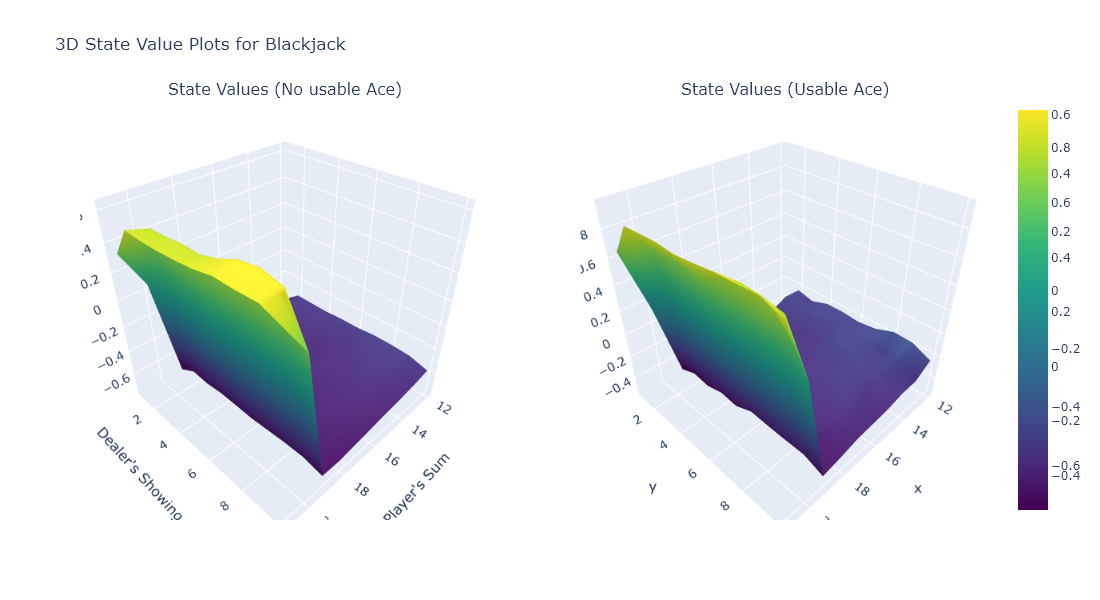

In [40]:
from IPython.display import Image
Image("blackjack_state_values.png")